# Importing Necessary Libraries

In [21]:
!pip install opendatasets

In [22]:
!pip install torchinfo

In [23]:
import torch
from torch import nn, optim
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
import seaborn as sns
from torchinfo import summary
import pandas as pd
import torch
from torchvision import datasets
import os
from torch.utils.data import Dataset, DataLoader
# from tqdm.notebook import tqdm_notebook
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision import models, transforms, utils
import os
from zipfile import ZipFile
import opendatasets as od
from pathlib import Path

# Setup device agnostic code

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Getting the dataset

In [25]:
if Path(".\\mood-image-dataset").is_dir():
    print("The dataset already exists. Skipping download....")
else:
    print("Downloading the dataset")
    od.download("https://www.kaggle.com/datasets/lavishalakhmani/mood-image-dataset?select=images")

Skipping, found downloaded files in "./mood-image-dataset" (use force=True to force download)


In [26]:
train_dir = Path(".\\mood-image-dataset\\images\\train")
test_dir = Path(".\\mood-image-dataset\\images\\validation")

# Preprocessing the dataset

In [27]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [28]:
train_data = datasets.ImageFolder(root="/content/mood-image-dataset/images/train",transform=transform)
test_data = datasets.ImageFolder(root="/content/mood-image-dataset/images/validation",transform=transform)
print(f"Length of train dataset = {len(train_data)}")
print(f"Length of test dataset = {len(test_data)}")
img,label=train_data[0]
print(f"Shape of image: {img.shape}")

Length of train dataset = 26921
Length of test dataset = 7066
Shape of image: torch.Size([3, 256, 256])


In [29]:
class_labels = train_data.classes
class_labels

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Preparing Dataloaders

In [10]:
BATCH_SIZE = 64

train_dataloader=DataLoader(dataset=train_data,
                           batch_size=BATCH_SIZE,
                           shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b22a22c30d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b22a22c3880>)

In [11]:
print(f"Length of training dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of testing dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of training dataloader: 421 batches of 64
Length of testing dataloader: 111 batches of 64


# Visulalizing Images from the dataset

In [13]:
example_img,example_label=next(iter(train_dataloader))
print(example_img.shape)
print(example_label.shape)

torch.Size([64, 3, 256, 256])
torch.Size([64])


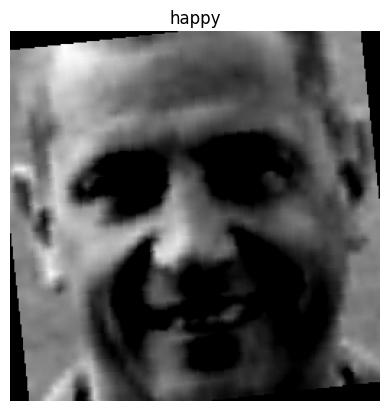

In [14]:
random_idx = torch.randint(0,len(example_label),size=[1]).item()
img,label=example_img[random_idx],example_label[random_idx]
# img=img.permute(1,2,0)
plt.imshow(img.permute(1,2,0))
plt.title(class_labels[label])
plt.axis(False)
plt.show()

# Building the Model

In [31]:
torch.manual_seed(3407)
model = nn.Sequential(OrderedDict([('Conv1', nn.Conv2d(3,32,kernel_size=(3,3),padding=(1,1))),
                                    ('Conv2', nn.Conv2d(32,64,kernel_size=(3,3),padding=(1,1))),
                                    ('ReLU1', nn.ReLU()),
                                    ('MaxPool1',nn.MaxPool2d(kernel_size=(3,3),padding=(1,1))),
                                    ('Conv3',nn.Conv2d(64,64,kernel_size=(3,3),padding=(1,1))),
                                    ('Conv4',nn.Conv2d(64,64,kernel_size=(3,3),padding=(1,1))),
                                    ('ReLU2',nn.ReLU()),
                                    ('MaxPool2',nn.MaxPool2d(kernel_size=(3,3),padding=(1,1))),
                                    ('Conv5',nn.Conv2d(64,64,kernel_size=(3,3),padding=(1,1))),
                                    ('Conv6',nn.Conv2d(64,128,kernel_size=(3,3),padding=(1,1))),
                                    ('ReLU3',nn.ReLU()),
                                    ('MaxPool3',nn.MaxPool2d(kernel_size=(3,3),padding=(1,1))),
                                    ('Flatten',nn.Flatten()),
                                    ('Layer1',nn.Linear(12800,128)),
                                    ('ReLU3',nn.ReLU()),
                                    ('Layer2',nn.Linear(128,64)),
                                    ('ReLU4',nn.ReLU()),
                                    ('Layer3',nn.Linear(64,7))
                                   ])).to(device)


In [16]:
summary(model, input_size=(1,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 7]                    --
├─Conv2d: 1-1                            [1, 32, 256, 256]         896
├─Conv2d: 1-2                            [1, 64, 256, 256]         18,496
├─ReLU: 1-3                              [1, 64, 256, 256]         --
├─MaxPool2d: 1-4                         [1, 64, 86, 86]           --
├─Conv2d: 1-5                            [1, 64, 86, 86]           36,928
├─Conv2d: 1-6                            [1, 64, 86, 86]           36,928
├─ReLU: 1-7                              [1, 64, 86, 86]           --
├─MaxPool2d: 1-8                         [1, 64, 29, 29]           --
├─Conv2d: 1-9                            [1, 64, 29, 29]           36,928
├─Conv2d: 1-10                           [1, 128, 29, 29]          73,856
├─ReLU: 1-11                             [1, 128, 29, 29]          --
├─MaxPool2d: 1-12                        [1, 128, 10, 10]       

# Setting up loss Function and Optimizer

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

## Early Stopping

In [33]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, restore_best_weights=True, path='checkpoint.pt', verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.path = path
        self.early_stop = False

    def __call__(self, val_loss, model):
        loss = val_loss

        if self.best_loss is None:
            self.best_loss = loss
            torch.save(model.state_dict(), self.path)
            # print("saved model1")
        elif loss - self.best_loss >=  self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = loss
            if self.restore_best_weights:
                torch.save(model.state_dict(), self.path)

            self.counter = 0

## training loop

In [34]:
%%time
num_epochs = 8
trainloss = []
testloss = []
trainaccuracy = []
testaccuracy = []
early_stopping = EarlyStopping(patience=10, verbose=True, delta = 0.001, path ="CNN_Classifier.pt")
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    correct_train = 0
    for train_images, train_labels in train_dataloader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(train_images.to(device))  # Forward pass
        train_loss = loss_fn(outputs, train_labels.to(device))  # Compute loss
        train_loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        _, train_pred = torch.max(outputs.data,dim=-1)
        # test_pred = train_outputs.data.max(1,keepdim=)
        correct_train += torch.eq(train_pred.to(device),train_labels.to(device)).sum()

        running_train_loss += train_loss.item()
        train_accuracy = 100*(correct_train/len(train_dataloader.dataset))

    avg_train_loss = running_train_loss / len(train_dataloader)
    correct_test = 0
    running_test_loss = 0.0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for test_images, test_labels in test_dataloader:
            test_outputs = model(test_images.to(device))
            test_loss = loss_fn(test_outputs, test_labels.to(device))
            _, test_pred = torch.max(test_outputs.data, 1)
            running_test_loss += test_loss.item()
            correct_test += torch.eq(test_pred.to(device),test_labels.to(device)).sum()
            test_accuracy = 100*(correct_test/len(test_dataloader.dataset))

    avg_test_loss = running_test_loss / len(test_dataloader)

    trainloss.append(avg_train_loss)
    testloss.append(avg_test_loss)
    testaccuracy.append(test_accuracy)
    trainaccuracy.append(train_accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}]| Train Loss: {avg_train_loss:.4f}| Train Accuracy: {train_accuracy:.2f}%| Test loss: {avg_test_loss:.4f}| Test Accuracy: {test_accuracy:.2f}%')
    early_stopping(avg_test_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch [1/8]| Train Loss: 1.7159| Train Accuracy: 30.34%| Test loss: 1.6374| Test Accuracy: 37.08%
Epoch [2/8]| Train Loss: 1.5271| Train Accuracy: 40.80%| Test loss: 1.5177| Test Accuracy: 39.99%
Epoch [3/8]| Train Loss: 1.4171| Train Accuracy: 44.74%| Test loss: 1.3895| Test Accuracy: 46.80%
Epoch [4/8]| Train Loss: 1.3442| Train Accuracy: 48.16%| Test loss: 1.3569| Test Accuracy: 47.48%
Epoch [5/8]| Train Loss: 1.2850| Train Accuracy: 50.45%| Test loss: 1.3071| Test Accuracy: 50.28%
Epoch [6/8]| Train Loss: 1.2378| Train Accuracy: 52.57%| Test loss: 1.2669| Test Accuracy: 52.18%
Epoch [7/8]| Train Loss: 1.2061| Train Accuracy: 53.66%| Test loss: 1.2611| Test Accuracy: 53.50%
Epoch [8/8]| Train Loss: 1.1678| Train Accuracy: 54.96%| Test loss: 1.2361| Test Accuracy: 53.59%
CPU times: user 28min 13s, sys: 2min 39s, total: 30min 53s
Wall time: 30min 53s


In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Functionating the Training and Testing loop

In [ ]:
# def train(model, data_loader, loss_fn, optimizer, accuracy_fn, epoch, device):
#     model.train()
#     train_loss, train_acc = 0, 0
#     for X, y in data_loader:
#         X, y = X.to(device), y.to(device)
#         y_pred = model(X)
#         loss = loss_fn(y_pred, y)
#         train_loss += loss.item()
#         train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     train_loss /= len(data_loader)
#     train_acc /= len(data_loader)
#     if epoch % 5 == 0:
#         print(f"Epoch {epoch}: Train loss: {train_loss:.5f}, Train accuracy: {train_acc:.2f}%")


# def test(data_loader, model, loss_fn, accuracy_fn, epoch, device):
#     model.eval()
#     test_loss, test_acc = 0, 0
#     with torch.no_grad():
#         for X, y in data_loader:
#             X, y = X.to(device), y.to(device)
#             y_pred = model(X)
#             test_loss += loss_fn(y_pred, y).item()
#             test_acc += accuracy_fn(y, y_pred.argmax(dim=1))
#     test_loss /= len(data_loader)
#     test_acc /= len(data_loader)
#     if epoch % 5 == 0:
#         print(f"Epoch {epoch}: Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")


In [ ]:
# def train(model:torch.nn.Module,
#           data_loader:torch.utils.data.DataLoader,
#           loss_fn:torch.nn.Module,
#           optimizer:torch.optim.Optimizer,
#           accuracy_fn,
#           epoch:int,
#           device: torch.device = device):
#     train_loss,train_acc = 0,0
#     model.to(device)

#     for batch, (X,y) in enumerate(data_loader):
#         X,y = X.to(device),y.to(device)

#         y_pred = model(X)

#         loss = loss_fn(y_pred,y)
#         train_loss += loss
#         train_acc += accuracy_fn(y,y_pred.argmax(dim=1))

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     train_loss /= len(data_loader)
#     train_acc /= len(data_loader)
#     if epoch%5==0:
#         print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

# def test(data_loader: torch.utils.data.DataLoader,
#          model: torch.nn.Module,
#          loss_fn: torch.nn.Module,
#          accuracy_fn,
#          epoch:int,
#          device: torch.device = device):
#     test_loss, test_acc = 0, 0
#     model.to(device)
#     model.eval() # put model in eval mode
#     # Turn on inference context manager
#     with torch.inference_mode():
#         for X, y in data_loader:
#             X, y = X.to(device), y.to(device)

#             test_pred = model(X)

#             test_loss += loss_fn(test_pred, y)
#             test_acc += accuracy_fn(y_true=y,
#                 y_pred=test_pred.argmax(dim=1)
#             )
#         test_loss /= len(data_loader)
#         test_acc /= len(data_loader)
#         if epoch%5==0:
#             print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
def train(model:torch.nn.Module,
          data_loader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          epoch:int,
          accuracy_fn,
          device:torch.device=device
         ):
    model.to(device)
    model.train() # Setting the model to training mode
    train_loss = 0
    train_acc = 0
    for batch, (X,y) in enumerate(data_loader): # By using this function we are accessing the images and their labels from dataset
        X,y=X.to(device),y.to(device)

        # Make the forward pass
        y_pred = model(X)

        # Calculate the loss and accuracy
        loss=loss_fn(y_pred,y)
        y_pred_class=y_pred.argmax(dim=1)
        acc=accuracy_fn(y,y_pred_class)

        # Accumulate the loss and accuracy
        train_loss+=loss
        train_acc+=acc

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        #Optimizer step
        optimizer.step()

    # Calculating the average training loss and accuracy
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    if epoch%5==0:
        print(f"Train Loss: {loss:.2f} | Average Train Loss: {train_loss:.2f} | Train Accuracy: {acc:.2f} | Average Train Accuracy: {train_acc:.2f}")


In [ ]:
def test(model:torch.nn.Module,
        data_loader:torch.utils.data.DataLoader,
        loss_fn:torch.nn.Module,
        accuracy_fn,
        epoch:int,
        device:torch.device=device):
    model.to(device)
    model.eval() # Setting the model to testing mode

    test_loss = 0
    test_acc = 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loader):
            X,y = X.to(device),y.to(device)

            # Make the forward Pass
            y_pred = model(X)

            # Calculate the loss and accuracy
            loss = loss_fn(y_pred,y)
            y_pred_class = y_pred.argmax(dim=1)
            acc = accuracy_fn(y,y_pred_class)

            # Accumulate the loss and accuracy
            test_loss += loss
            test_acc +=acc

        # Calculating the average testing loss and accuracy
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        if epoch%5==0:
            print(f"Test Loss: {loss:.2f} | Average Test Loss: {test_loss:.2f} | Test Accuracy: {acc:.2f} | Average Test Accuracy: {test_acc:.2f}")


# Function for getting training time

In [ ]:
from timeit import default_timer as timer

def print_train_time(start: float,end:float,device: torch.device=True):
  """Prints differecnce between start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

# Training

In [ ]:
def loop(train_dataloader,test_dataloader,model,accuracy_fn,loss_fn,optimizer,device):
    train_time_start = timer()
    epochs = 30
    for epoch in tqdm(range(epochs)):
        if epoch%5==0:
            print(f"Epoch: {epoch}\n---------")

        train(data_loader=train_dataloader,
             model=model,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             epoch=epoch,
             device=device)

        test(data_loader=test_dataloader,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            epoch=epoch,
            device=device)

    train_time_end=timer()
    print_train_time(train_time_start,train_time_end,device)
    return model

In [ ]:
mood_detector = loop(train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    model=model,
                    loss_fn=loss_fn,
                    accuracy_fn=accuracy_fn,
                    optimizer=optimizer,
                    device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss: 2.31 | Average Train Loss: 1.80 | Train Accuracy: 11.11 | Average Train Accuracy: 25.48
Test Loss: 2.20 | Average Test Loss: 1.81 | Test Accuracy: 0.00 | Average Test Accuracy: 25.81
Epoch: 5
---------
Train Loss: 1.79 | Average Train Loss: 1.80 | Train Accuracy: 22.22 | Average Train Accuracy: 25.49
Test Loss: 2.26 | Average Test Loss: 1.81 | Test Accuracy: 0.00 | Average Test Accuracy: 25.81
Epoch: 10
---------
Train Loss: 1.82 | Average Train Loss: 1.80 | Train Accuracy: 22.22 | Average Train Accuracy: 25.49
Test Loss: 2.22 | Average Test Loss: 1.81 | Test Accuracy: 0.00 | Average Test Accuracy: 25.81
Epoch: 15
---------
Train Loss: 1.63 | Average Train Loss: 1.80 | Train Accuracy: 33.33 | Average Train Accuracy: 25.50
Test Loss: 2.31 | Average Test Loss: 1.81 | Test Accuracy: 0.00 | Average Test Accuracy: 25.81
Epoch: 20
---------
Train Loss: 1.80 | Average Train Loss: 1.80 | Train Accuracy: 22.22 | Average Train Accuracy: 25.49
Test Loss: 2.22 | Aver

In [ ]:
MODEL_PATH = Path(".\\")
MODEL_PATH.mkdir(parents=True,exist_ok=True)
MODEL_NAME = 'mood_detector.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
print(f"Saving model to:- {MODEL_SAVE_PATH}")
torch.save(mood_detector,MODEL_SAVE_PATH)